In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import os
import numpy as np
from astropy.table import Table
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime

t = Table.read('obs_ms_table.dat', format='ascii')
msd = t['gui_ms'] == 'DISA'
print DateTime(t['time'][-1]).date

2016:094:01:20:55.837


In [7]:
def one_shot_plot(t, label=None):
    msd = t['gui_ms'] == 'DISA'
    figure(figsize(7, 5))
    plot(t['manvr_angle'][~msd], t['one_shot'][~msd], 'b+', markersize=5, markeredgewidth=.8,
        label='last dwell MSF ENAB')
    plot(t['manvr_angle'][msd], t['one_shot'][msd], 'rx', markersize=5, markeredgewidth=.8,
         label='last dwell MSF DISA')
    grid()
    xlim(0, 185)
    ylim(-1, 80)
    ylabel('One Shot (arcsec)')
    xlabel('Manvr Angle (deg)')
    legend(loc='upper left', fontsize=10, numpoints=1, handletextpad=0)
    title('One Shot Magnitude ({})'.format(label), fontsize=12)
    tight_layout()

One shots of last 6 months of data

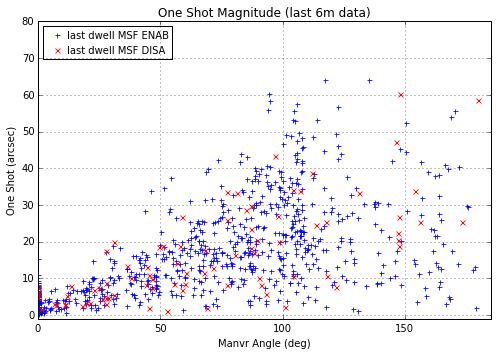

In [8]:
one_shot_plot(t, 'last 6m data')

One shots of data since beginning of MAR0516 schedule

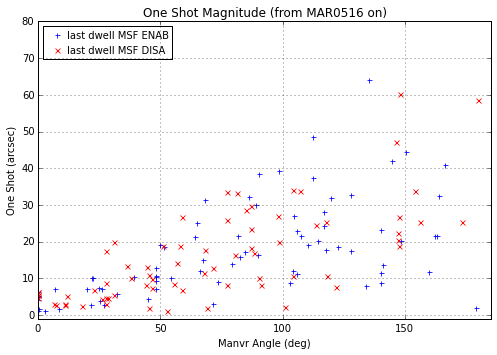

In [9]:
# select observations at and after 51213 (beginning of MAR0516 schedule)
recent = t[t['time'] >= t[t['obsid'] == 51213]['time']]
one_shot_plot(recent, 'from MAR0516 on')

In [10]:
def att_err_time_plots(t, min_dwell_time=0):
    t = t[(t['timestop'] - t['time']) >= min_dwell_time]
    msd = t['gui_ms'] == 'DISA'
    for i, ax in enumerate(['roll', 'pitch', 'yaw'], 1):
        figure(figsize(7, 5))
        lim = 21
        if ax == 'roll':
            lim = 56
        plot_cxctime(t['time'][~msd], t['{}_err'.format(ax)][~msd], 'b+', markersize=5,
                     label='MSF ENAB')
        plot_cxctime(t['time'][msd], t['{}_err'.format(ax)][msd], 'rx', markersize=5,
                     label='MSF DISA')
        title('90th percentile {} error (AOATTER{}) magnitude (per obs)'.format(ax, i),
              fontsize=12)
        grid()
        ylabel('{} err (arcsec)'.format(ax))
        legend(loc='upper left', fontsize=10, numpoints=1)
        if min_dwell_time == 0:
            ylim(-1, lim) 
        margins(.1)
        tight_layout()

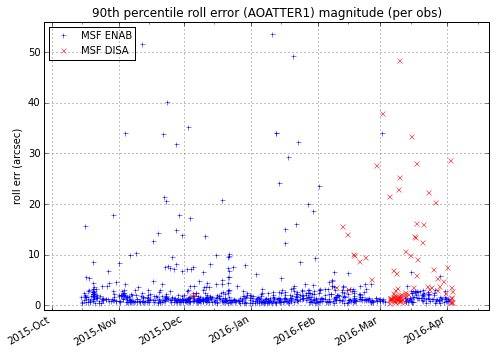

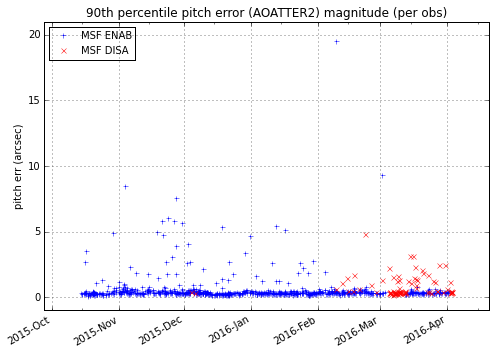

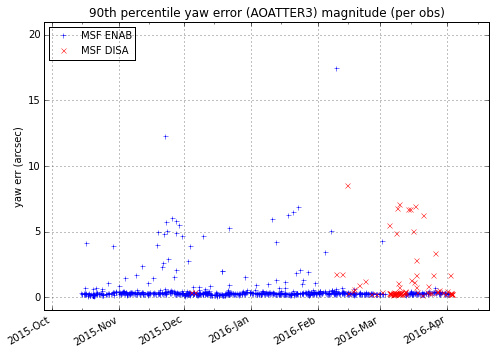

In [11]:
att_err_time_plots(t)

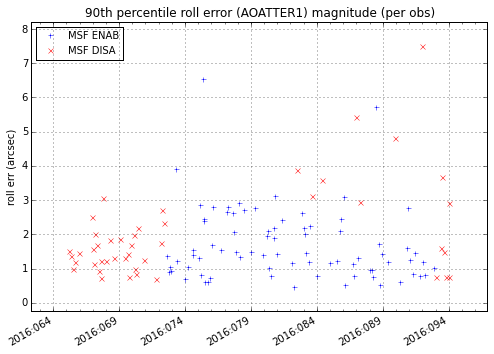

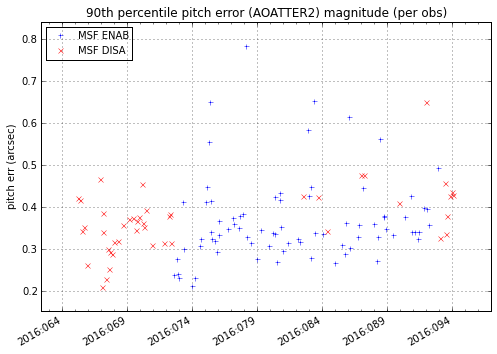

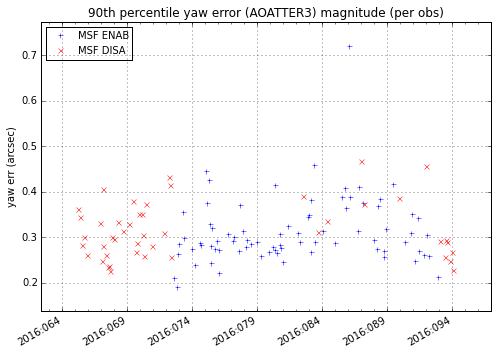

In [21]:
att_err_time_plots(recent, min_dwell_time=1000)

In [20]:
def att_err_plots(t, label=None, scale_norm=False):
    msd = t['gui_ms'] == 'DISA'
    for i, ax in enumerate(['roll', 'pitch', 'yaw'], 1):
        figure(figsize(9, 3.5))
        lim = 21
        if ax == 'roll':
            lim = 56
        bins = np.arange(0, lim, 1)
        ax1 = subplot(1, 2, 1)
        h1 = hist(t['{}_err'.format(ax)][~msd], bins=bins, log=True, color='b',
             alpha=.4, label='MSF ENAB')
        ylim(.5)
        ylims = ylim()
        if scale_norm:
            ylabel('N obs', color='b')
            ax1p5 = ax1.twinx()
        h2 = hist(t['{}_err'.format(ax)][msd], bins=bins, log=True, color='r',
             alpha=.4, label='MSF DISA')
        title('90th percentile {} error (AOATTER{}) magnitude (per obs)'.format(ax, i),
              fontsize=8)
        xlabel('{} err (arcsec)'.format(ax))
        if scale_norm:
            # scale the right axis to have the peak of the  MS disabled data match the
            # corresponding point on the all-data histogram
            idx_max = np.argmax(h1[0])
            min_h1 = .5
            yrange = log10(ylims[1]) - log10(ylims[0])
            all_data_range = log10(h1[0][idx_max]) - log10(ylims[0])
            ratio = all_data_range / yrange
            msf_data_range = log10(h2[0][idx_max]) - log10(min_h1)
            mymax = (msf_data_range / ratio) + log10(min_h1)
            ylim(min_h1, 10**mymax)

            p1, l1 = ax1.get_legend_handles_labels()
            p2, l2 = ax1p5.get_legend_handles_labels()
            for tl in ax1.get_yticklabels():
                tl.set_color('b')
            for tl in ax1p5.get_yticklabels():
                tl.set_color('r')
            ylabel('MSF N obs', color='r', rotation=270)
            legend(p1 + p2, l1 + l2, loc='upper right', fontsize=8)
        else:
            legend(loc='upper right', fontsize=8)
            
        ax2 = subplot(1, 2, 2)
        plot_cxctime(t['time'][~msd], t['{}_err'.format(ax)][~msd], 'b+', markersize=3,
                     label='MSF ENAB')
        plot_cxctime(t['time'][msd], t['{}_err'.format(ax)][msd], 'rx', markersize=3,
                     label='MSF DISA')
        title('90th percentile {} error (AOATTER{}) magnitude (per obs)'.format(ax, i),
              fontsize=8)
        grid()
        ylabel('{} err (arcsec)'.format(ax))
        legend(loc='upper left', fontsize=8, numpoints=1)
        ylim(-1, lim) 
        margins(.1)
        tight_layout()
        subplots_adjust(wspace=.3)


Attitude errors of last 6 months of data with observations with MSF disabled (full duration) marked in red

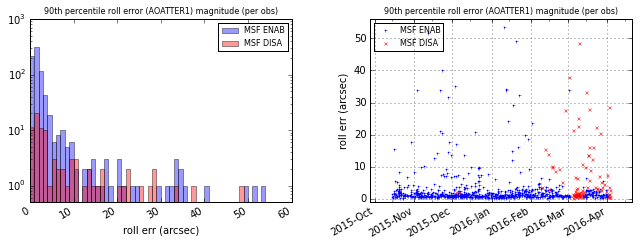

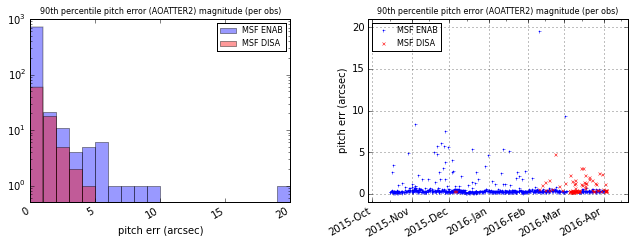

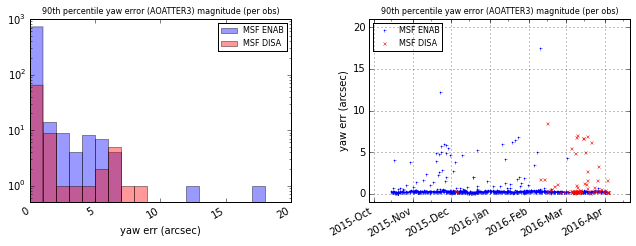

In [14]:
att_err_plots(t)

Attitude errors of last 6 months of data with the MSF disabled axis scaled such that the
peaks of the MSF enabled and MSF disabled data match.

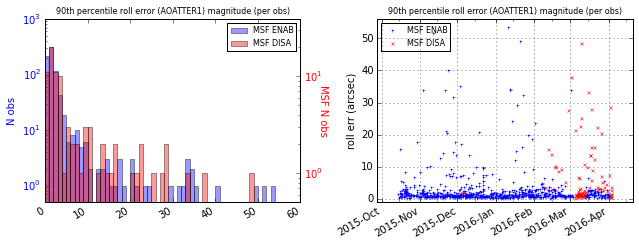

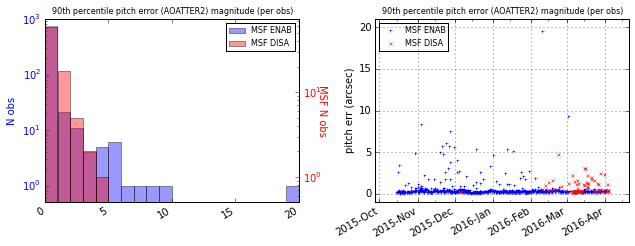

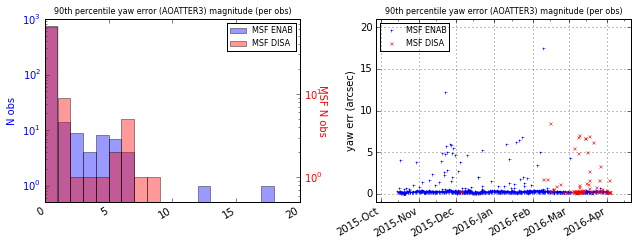

In [15]:
att_err_plots(t, scale_norm=True)

Attitude errors data beginning with MAR0516 schedule with observations with MSF disabled (full duration) marked in red

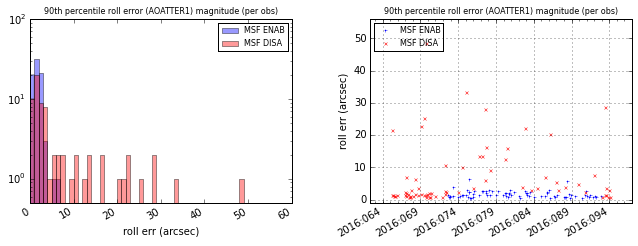

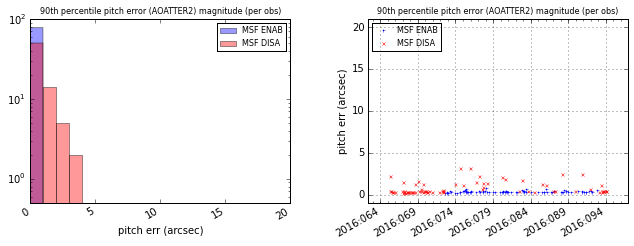

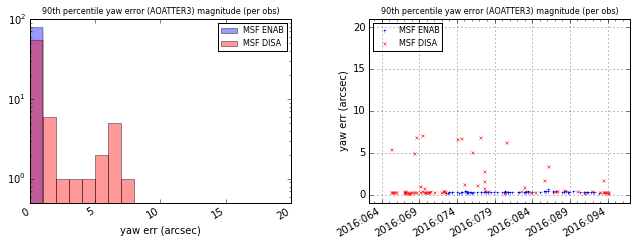

In [16]:
att_err_plots(recent)

Attitude errors data beginning with MAR0516 schedule with the MSF disabled axis scaled such that the
peaks of the MSF enabled and MSF disabled data match.

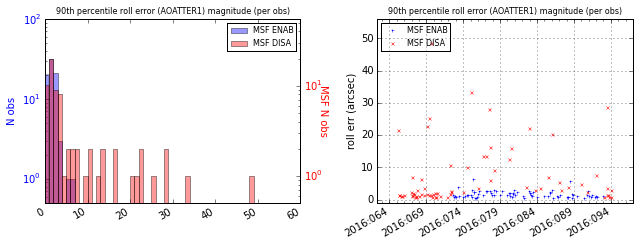

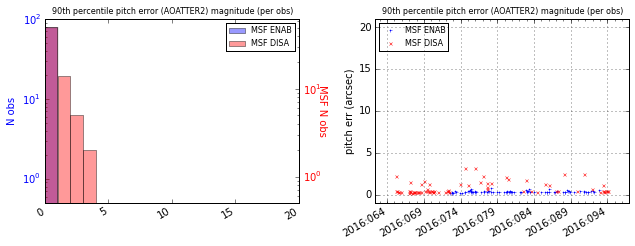

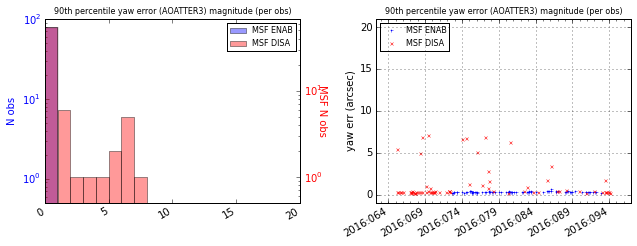

In [17]:
att_err_plots(recent, scale_norm=True)